### Figures for the Dinkey Creek treatment effects on C balance paper
####Cornerstones of this paper are that:
* Severe fire events will be more prevalent in future climates
* Via management, we can reduce fire severity across the landscape



In [27]:
# ------- Notebook config
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15.0, 12.0)
import matplotlib.pyplot as plt

# ------- Load dependencies
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import pysal as ps 
import gdal

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon as PolygonM

import rasterio
import os
from rasterstats import zonal_stats

# -------- Set working directory
wrkdir = 'Z:\Dan K\DinkeyCreek\LANDIS_RUNS\\'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [6]:
def __pysal_choro(values, scheme, k=5):
    """ Wrapper for choropleth schemes from PySAL for use with plot_dataframe

        Parameters
        ----------

        values
            Series to be plotted

        scheme
            pysal.esda.mapclassify classificatin scheme ['Equal_interval'|'Quantiles'|'Fisher_Jenks']

        k
            number of classes (2 <= k <=9)

        Returns
        -------

        values
            Series with values replaced with class identifier if PySAL is available, otherwise the original values are used
    """

    try:
        from pysal.esda.mapclassify import Quantiles, Equal_Interval, Fisher_Jenks
        schemes = {}
        schemes['equal_interval'] = Equal_Interval
        schemes['quantiles'] = Quantiles
        schemes['fisher_jenks'] = Fisher_Jenks
        s0 = scheme
        scheme = scheme.lower()
        if scheme not in schemes:
            scheme = 'quantiles'
            print('Unrecognized scheme: ', s0)
            print('Using Quantiles instead')
        if k < 2 or k > 9:
            print('Invalid k: ', k)
            print('2<=k<=9, setting k=5 (default)')
            k = 5
        binning = schemes[scheme](values, k)
        values = binning.yb
    except ImportError:
        print('PySAL not installed, setting map to default')

    return binning

def plot_polygon(ax, poly, facecolor='red', edgecolor='black', alpha=0.5, linewidth=1):
    """ Plot a single Polygon geometry """
    from descartes.patch import PolygonPatch
    a = np.asarray(poly.exterior)
    # without Descartes, we could make a Patch of exterior
    ax.add_patch(PolygonPatch(poly, facecolor=facecolor, alpha=alpha))
    ax.plot(a[:, 0], a[:, 1], color=edgecolor, linewidth=linewidth)
    for p in poly.interiors:
        x, y = zip(*p.coords)
        ax.plot(x, y, color=edgecolor, linewidth=linewidth)

def plot_multipolygon(ax, geom, facecolor='red', edgecolor='black', alpha=0.5, linewidth=1):
    """ Can safely call with either Polygon or Multipolygon geometry
    """
    if geom.type == 'Polygon':
        plot_polygon(ax, geom, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, linewidth=linewidth)
    elif geom.type == 'MultiPolygon':
        for poly in geom.geoms:
            plot_polygon(ax, poly, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, linewidth=linewidth)

from geopandas.plotting import (plot_linestring, plot_point, norm_cmap)


def plot_dataframe(s, column=None, colormap=None, alpha=0.5,
                   categorical=False, legend=False, axes=None, scheme=None,
                   k=5, linewidth=1):
    """ Plot a GeoDataFrame

        Generate a plot of a GeoDataFrame with matplotlib.  If a
        column is specified, the plot coloring will be based on values
        in that column.  Otherwise, a categorical plot of the
        geometries in the `geometry` column will be generated.

        Parameters
        ----------

        GeoDataFrame
            The GeoDataFrame to be plotted.  Currently Polygon,
            MultiPolygon, LineString, MultiLineString and Point
            geometries can be plotted.

        column : str (default None)
            The name of the column to be plotted.

        categorical : bool (default False)
            If False, colormap will reflect numerical values of the
            column being plotted.  For non-numerical columns (or if
            column=None), this will be set to True.

        colormap : str (default 'Set1')
            The name of a colormap recognized by matplotlib.

        alpha : float (default 0.5)
            Alpha value for polygon fill regions.  Has no effect for
            lines or points.

        legend : bool (default False)
            Plot a legend (Experimental; currently for categorical
            plots only)

        axes : matplotlib.pyplot.Artist (default None)
            axes on which to draw the plot

        scheme : pysal.esda.mapclassify.Map_Classifier
            Choropleth classification schemes

        k   : int (default 5)
            Number of classes (ignored if scheme is None)


        Returns
        -------

        matplotlib axes instance
    """
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.colors import Normalize
    from matplotlib import cm

    if column is None:
        return plot_series(s.geometry, colormap=colormap, alpha=alpha, axes=axes)
    else:
        if s[column].dtype is np.dtype('O'):
            categorical = True
        if categorical:
            if colormap is None:
                colormap = 'Set1'
            categories = list(set(s[column].values))
            categories.sort()
            valuemap = dict([(k, v) for (v, k) in enumerate(categories)])
            values = [valuemap[k] for k in s[column]]
        else:
            values = s[column]
        if scheme is not None:
            binning = __pysal_choro(values, scheme, k=k)
            values = binning.yb
            # set categorical to True for creating the legend
            categorical = True
            binedges = [binning.yb.min()] + binning.bins.tolist()
            categories = ['{0:.2f} - {1:.2f}'.format(binedges[i], binedges[i+1]) for i in range(len(binedges)-1)]
        cmap = norm_cmap(values, colormap, Normalize, cm)
        if axes == None:
            fig = plt.gcf()
            fig.add_subplot(111, aspect='equal')
            ax = plt.gca()
        else:
            ax = axes
        for geom, value in zip(s.geometry, values):
            if geom.type == 'Polygon' or geom.type == 'MultiPolygon':
                plot_multipolygon(ax, geom, facecolor=cmap.to_rgba(value), alpha=alpha, linewidth=linewidth)
            elif geom.type == 'LineString' or geom.type == 'MultiLineString':
                plot_multilinestring(ax, geom, color=cmap.to_rgba(value))
            # TODO: color point geometries
            elif geom.type == 'Point':
                plot_point(ax, geom, color=cmap.to_rgba(value))
        if legend:
            if categorical:
                patches = []
                for value, cat in enumerate(categories):
                    patches.append(Line2D([0], [0], linestyle="none",
                                          marker="o", alpha=alpha,
                                          markersize=15, markerfacecolor=cmap.to_rgba(value)))
                ax.legend(patches, categories, numpoints=1, loc='best')
            else:
                # TODO: show a colorbar
                raise NotImplementedError

    plt.draw()
    return ax

### Area map


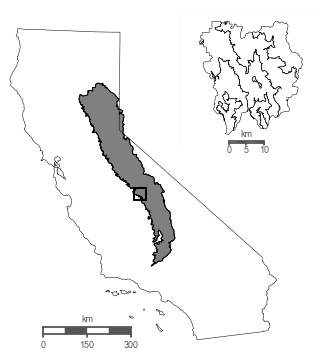

In [62]:


wrkDir = 'C:/Research/Dinkey_Creek/GIS_Data_And_Maps/'


shp = fiona.open(wrkDir + 'SierrasNad.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

shp = fiona.open(wrkDir + 'DinkeyElevationShp.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords2 = list(chain(ll, ur))
w, h = coords2[2] - coords2[0], coords2[3] - coords2[1]



fig1 = plt.figure(figsize = (6,6))
ax = fig1.add_subplot(111, frameon = False)

m = Basemap(llcrnrlon=-124,llcrnrlat=32.4,urcrnrlon=-111.5,urcrnrlat=42.5,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3, ax = ax)

m.drawmapscale(
    coords[0] + .5, coords[1] - 2,
    coords[0], coords[1],
    300.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1)

    
m.readshapefile(wrkDir + 'SierrasNad', 'Sierra',
    color='black', zorder=5)
sierraPatches = []

for info, shape in zip(m.Sierra_info, m.Sierra):
    if info['SECTION_NA'] == 'Sierra Nevada':
        sierraPatches.append( PolygonM(np.array(shape), True) )
ax.add_collection(PatchCollection(sierraPatches, 
          facecolor= 'grey', edgecolor='k', linewidths=1., zorder=2))

m.readshapefile(wrkDir + 'CaliforniaBoundary', 'Cali',
    color='black', zorder = 8)


axins = zoomed_inset_axes(ax, 12, loc=1)
m2 = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             projection='tmerc', lat_0 = 37.1, lon_0 = -119.3, ax = axins)
m2.fillcontinents(color='white')
m2.readshapefile(wrkDir + 'DinkeyElevationShp', 'Elevation',
    color='black',ax = axins)

elev = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m2.Elevation]})
for shape in enumerate(df_map['poly']):
    keys, values = m2.Elevation_info[shape[0]].keys(),m2.Elevation_info[shape[0]].values()
    elev.append(values[1])
df_map['Elevation'] = elev
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
elevFC = ['#f1eef6','#bdc9e1','#74a9cf','#2b8cbe','#045a8d']
idx = 0 # Colormap iterator
for feature in np.unique(df_map.Elevation):
    axins.add_collection(PatchCollection(df_map.patches[df_map.Elevation == feature], facecolor= elevFC[idx]))
    idx = idx + 1

m2.drawmapscale(
    coords2[0] + 0.15, coords2[1] - 0.02,
    coords2[0], coords2[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=2)

lbx2, lby2 = m(*m2(m2.xmin, m2.ymin, inverse= True))
ltx2, lty2 = m(*m2(m2.xmin, m2.ymax, inverse= True))
rtx2, rty2 = m(*m2(m2.xmax, m2.ymax, inverse= True))
rbx2, rby2 = m(*m2(m2.xmax, m2.ymin, inverse= True))

verts2 = [
    (lbx2, lby2), # left, bottom
    (ltx2, lty2), # left, top
    (rtx2, rty2), # right, top
    (rbx2, rby2), # right, bottom
    (lbx2, lby2), # ignored
    ]

codes2 = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(verts2, codes2)
patch = patches.PathPatch(path, facecolor = 'none', lw=2, zorder = 6)
ax.add_patch(patch)
plt.savefig('AreaMap.tif', dpi = 700)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
import matplotlib.patches as patches

m = Basemap(llcrnrlon=-121.7,llcrnrlat=34.4,urcrnrlon=-114.5,urcrnrlat=40.5,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3, ax = ax)


In [156]:
# Specify the name of our vector
mgmt = 'mgmtUnit_5070.shp'

mgmtUnits = gpd.GeoDataFrame.from_file(wrkdir + mgmt)
mgmtUnits_crs = mgmtUnits.crs
summedNEE = 'NEEmapS.tif'

metrics = "min max mean median std range".split()
stats = zonal_stats(wrkdir + mgmt, wrkdir + summedNEE, stats=metrics, nodata = -9999)

df = pd.DataFrame(stats)
df.head()
sim = 'SevereWFxThinRx'
new_colnames = ["{}_{}".format(sim, metric) for metric in metrics]
df2 = df.rename(columns=dict(zip(metrics, new_colnames)))
df2.head()
df3 = mgmtUnits.join(df2)
df3.head()

df3.__class__ = gpd.GeoDataFrame
df3.crs = mgmtUnits.crs
df3.set_geometry('geometry')

df3.head()
df3.SevereWFxThinRx_mean = df3.SevereWFxThinRx_mean * 100

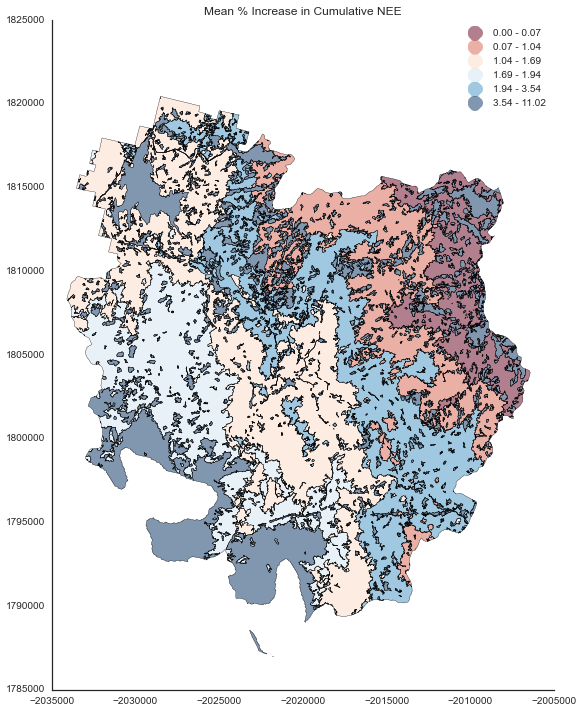

In [75]:
plot_dataframe(df3, column='SevereWFxThinRx_mean', scheme='Quantiles', 
                    k=6, colormap='RdBu', 
                    legend = True, linewidth = 0.2)
plt.title('Mean % Increase in Cumulative NEE')
sns.despine()
plt.savefig('CumulativeNEE_PercentIncrease.tif', dpi = 300)

In [64]:
# pull out the pixels in each of the six management areas, each into a separate dataframe,
# then concatenate them for plotting


dataraster = gdal.Open(wrkdir + 'NEEmapS.tif').ReadAsArray()
templateraster = gdal.Open(wrkdir + 'MgmtRedux.tif').ReadAsArray()
sim = 'SevereTxRx'
dataraster[dataraster == -9999] = np.nan
count = 0

for ID in np.unique(templateraster):
    ID_data = dataraster[templateraster == ID]
    if count == 0:
        zonalData = pd.DataFrame(dict(Data = ID_data))
        zonalData['Unit'] = ID
        zonalData['Sim'] = sim
    else:
        toAppend = pd.DataFrame(dict(Data = ID_data))
        toAppend['Unit'] = ID
        toAppend['Sim'] = sim

        zonalData = pd.concat([zonalData, toAppend])
    count = count + 1
    
dataraster = gdal.Open(wrkdir + 'NEEmapH.tif').ReadAsArray()
templateraster = gdal.Open(wrkdir + 'MgmtRedux.tif').ReadAsArray()
sim = 'HistoricTxRx'
dataraster[dataraster == -9999] = np.nan
count = 0

for ID in np.unique(templateraster):
    ID_data = dataraster[templateraster == ID]
    if count == 0:
        zonalDataH = pd.DataFrame(dict(Data = ID_data))
        zonalDataH['Unit'] = ID
        zonalDataH['Sim'] = sim
    else:
        toAppend = pd.DataFrame(dict(Data = ID_data))
        toAppend['Unit'] = ID
        toAppend['Sim'] = sim

        zonalDataH = pd.concat([zonalDataH, toAppend])
    count = count + 1

zonalDataH = zonalDataH.dropna()
zonalData = zonalData.dropna()

zonalDataT = pd.concat([zonalData, zonalDataH])
#zonalDataT[zonalDataT.Data > 1] = np.nan
#zonalDataT[zonalDataT.Data < -1] = np.nan
zonalDataT[zonalDataT.Unit == 0] = np.nan
zonalDataT.Data = zonalDataT.Data / 100

### Filter the data by management unit to exclude the 99th and 1st percentile data
Because we are using KDE's to plot split violin plots, outliers really mess with the way the density estimates are drawn. We don't have to remove many points to get nice looking figures. Here, we call outliers any datapoint that falls outside the 99th percentile of data.

In [162]:
count = 0
for unit in np.unique(zonalDataT.Unit):
    unitsub = zonalDataT[zonalDataT.Unit == unit]
    if count == 0:
        capT = unitsub[(unitsub.Data < unitsub.Data.quantile(.99)) & (unitsub.Data > unitsub.Data.quantile(.01))]
    else:
        cap = unitsub[(unitsub.Data < unitsub.Data.quantile(.99)) & (unitsub.Data > unitsub.Data.quantile(.01))]
        capT = pd.concat([capT, cap])
    #print 'excluding data larger than ' + str(unitsub.Data.quantile(.99))
    count = count + 1

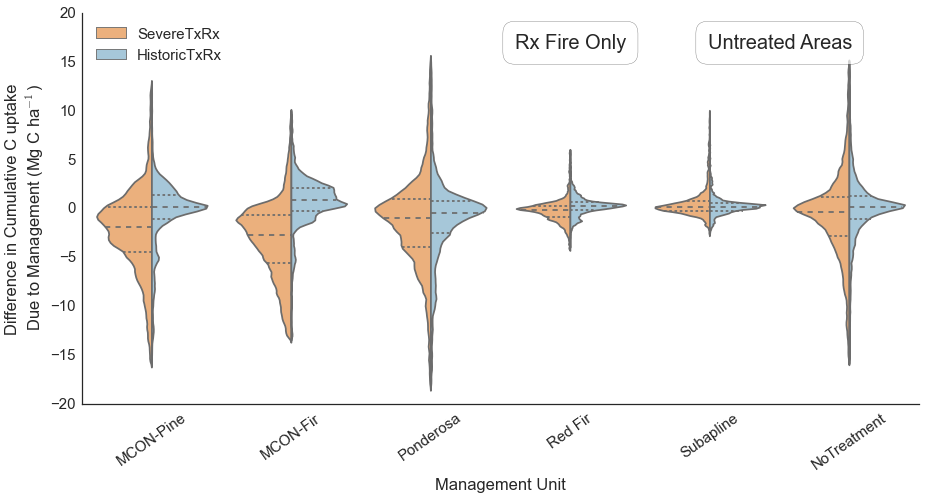

In [155]:
burnSevColors = ["#fdae6b","#9ecae1"]
burnSev = sns.color_palette(burnSevColors)

f, (ax1) = plt.subplots(1, figsize = (15, 7))

mgmtViolin = sns.violinplot(x="Unit", y="Data", hue="Sim",
                     data=capT, palette=sns.color_palette(burnSevColors),
                     split=True, scale = 'count', 
                     inner="quartile", bw = 0.06,
                     ax = ax1)
sns.despine()
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
ax1.set_xlabel('Management Unit')
ax1.set_xticklabels(['MCON-Pine', 'MCON-Fir', 
                     'Ponderosa','Red Fir',
                     'Subapline','NoTreatment'],
                    rotation = 35)
ax1.set_ylabel('Difference in Cumulative C uptake \n Due to Management (Mg C ha$^{-1}$)')
ax1.legend(loc = 2)

bbox_props = dict(boxstyle="round, pad =0.6", fc="w", ec="black", alpha=0.7)
ax1.text(4.5, 17, "Untreated Areas", ha="center", va="center", size=20,
        bbox=bbox_props)

ax1.text(3, 17, "Rx Fire Only", ha="center", va="center", size=20,
        bbox=bbox_props)
plt.savefig('NEE_Diff_NM-ThRx_His_Sev.tif', dpi = 300)

-17